In [1]:
import numpy as np
import cv2
%pylab inline
#%matplotlib auto

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#plt.ioff()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

Text(0.5,1,'Undistorted Image')

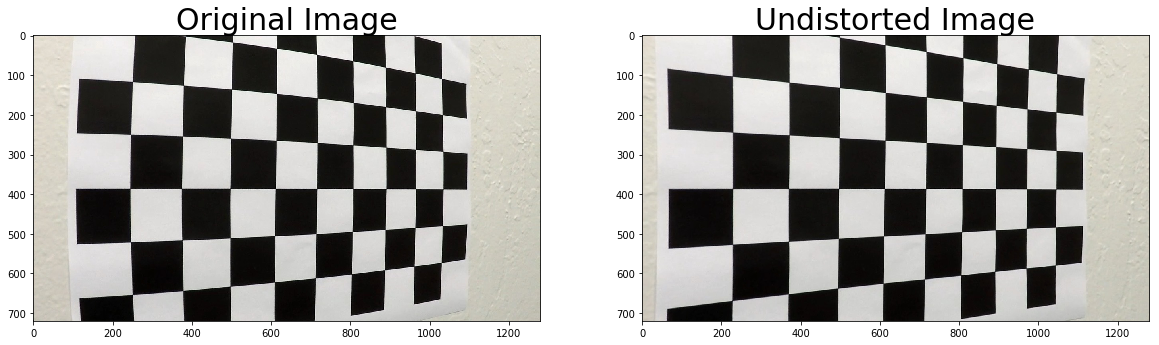

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_Cal/calibration5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/calibration5.jpg',cv2.cvtColor(dst, cv2.COLOR_RGB2BGR))

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "test_images/pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, )
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
def histogram_equalize(img):
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels
    l2 = clahe.apply(l)  # apply CLAHE to the L-channel
    lab = cv2.merge((l2,a,b))  # merge channels
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return img2

In [5]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.fitx = None  
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [6]:
def points_map(img, image_name):    
    img = np.copy(img)
    img_size=(img.shape[1], img.shape[0])
    img_original=np.copy(img)
    (580, 460), (205, 720), (1110, 720), (703, 460)
    #perspective transform
    
    src = np.float32(
    [[(img_size[0] / 2) - 65, img_size[1] / 2 + 95],
    [((img_size[0] / 6) - 10), img_size[1]-35],
    [(img_size[0] * 5 / 6) + 60, img_size[1]-35],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 95]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    pts = np.array([src], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img, [pts], True, (0,255,255), 3)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Points', fontsize=30)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    warped_original = cv2.warpPerspective(img_original, M, img_size, flags=cv2.INTER_LINEAR)
    img=np.copy(warped)
    img_double=histogram_equalize(img)  
    
    pts = np.array([dst], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(warped_original, [pts], True, (0,255,255), 3)
    ax2.imshow(warped_original, )
    ax2.set_title('warped Image', fontsize=30)
    plt.show()

In [7]:
def pipeline_challenge(img, image_name):    
    img = np.copy(img)
    img_size=(img.shape[1], img.shape[0])

    #keep the original image for use
    img_original=np.copy(img)
    
    #histogram equalize the image to increase the contrast
    img=histogram_equalize(img)    
     
    #perspective transform
    src = np.float32(
    [[(img_size[0] / 2) - 40, img_size[1] / 2 + 110],
    [((img_size[0] / 6) - 0), img_size[1]-35],
    [(img_size[0] * 5 / 6) + 70, img_size[1]-35],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 110]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
       
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    warped_original = cv2.warpPerspective(img_original, M, img_size, flags=cv2.INTER_LINEAR)
    img=np.copy(warped)
    img_double=histogram_equalize(img)  
        
    #hls channel. s channel has both original and hisogram equalization image for later use
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_original=cv2.cvtColor(warped_original, cv2.COLOR_RGB2HLS)
    hls_double = cv2.cvtColor(img_double, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls_original[:,:,1]
    s_channel = hls[:,:,2]
    s_channel_original=hls_original[:,:,2]
    s_channel_double = hls_double[:,:,2]
   
    #rgb channel, r channel could use both original and hisogram equalization image
    r_channel = img[:,:,0]
    r_channel_original = warped_original[:,:,0]
    r_channel_double = img_double[:,:,0]
    g_channel = img[:,:,1]
    g_channel_double = img_double[:,:,1]
    b_channel = warped_original[:,:,2]
    b_channel_double = img_double[:,:,2]
    
    # Sobel x for s channel
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1 
    
    # Sobel x for b channel
    sobelx1 = cv2.Sobel(b_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))
    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= 15) & (scaled_sobel1 <= 40)] = 1
    
    # Sobel x for b channel double
    sobelx1 = cv2.Sobel(b_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))
    sxbinary2 = np.zeros_like(scaled_sobel1)
    sxbinary2[(scaled_sobel1 >= 5) & (scaled_sobel1 <= 20)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 210) & (s_channel <= 255)] = 1
    
    s_binary_original = np.zeros_like(s_channel_original)
    s_binary_original[(s_channel_original >= 210) & (s_channel_original <= 255)] = 1
    
    s_binary_double = np.zeros_like(s_channel_double)
    s_binary_double[(s_channel_double >= 210) & (s_channel_double <= 255)] = 1
    
    r_binary_original = np.zeros_like(r_channel_original)
    r_binary_original[(r_channel_original >= 220) & (r_channel_original <= 255)] = 1
    
    r_binary_double = np.zeros_like(r_channel_double)
    r_binary_double[(r_channel_double >= 235) & (r_channel_double <= 255)] = 1
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= 220) & (r_channel <= 255)] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 30) & (h_channel <= 100)] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 170) & (l_channel <= 255)] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 170) & (b_channel <= 255)] = 1

    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= 220) & (g_channel <= 255)] = 1
    
    g_binary_double = np.zeros_like(g_channel_double)
    g_binary_double[(g_channel_double >= 220) & (g_channel_double <= 255)] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 200) & (b_channel <= 255)] = 1
   
    #change color binary to gray
    color_binary = np.dstack(( r_binary, sxbinary1, s_binary)) * 255
    gray = cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)    
    gray_binary = np.zeros_like(gray)
    gray_binary[(gray >= 150) & (gray <= 255)] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(r_binary_original == 1)| (r_binary == 1)| (g_binary == 1)|  (l_binary == 1)| (b_binary == 1) |(gray_binary ==1 ) |(sxbinary2 ==1 )  ] = 1
    combined_binary[ (r_binary_original == 1)| (r_binary == 1) | (r_binary_double == 1)| (s_binary == 1)|  (s_binary_original == 1) |  (s_binary_double == 1)  ] = 1

    
    #plt show for debug purpose
#     plt.imshow(img, cmap='gray')
#     plt.title(image_name)
#     plt.show()
    
#     plt.imshow(h_channel, cmap='gray')
#     plt.title(image_name + "h_channel")
#     plt.show()
    
#     plt.imshow(l_channel, cmap='gray')
#     plt.title(image_name + "l_channel")
#     plt.show()
    
#     plt.imshow(s_channel, cmap='gray')
#     plt.title(image_name + "s_channel")
#     plt.show()
    
#     plt.imshow(r_channel, cmap='gray')
#     plt.title(image_name + "r_channel")
#     plt.show()
    
#     plt.imshow(g_channel, cmap='gray')
#     plt.title(image_name + "g_channel")
#     plt.show()
    
#     plt.imshow(b_channel, cmap='gray')
#     plt.title(image_name + "b_channel")
#     plt.show()
    
#     plt.imshow(g_binary, cmap='gray')
#     plt.title(image_name + "g_binary")
#     plt.show()
    
#     plt.imshow(g_binary_double, cmap='gray')
#     plt.title(image_name + "g_binary_double")
#     plt.show()
    
#     plt.imshow(s_binary, cmap='gray')
#     plt.title(image_name + "s_binary")
#     plt.show()
    
#     plt.imshow(s_binary_original, cmap='gray')
#     plt.title(image_name + "s_binary_original")
#     plt.show()
    
#     plt.imshow(s_binary_double, cmap='gray')
#     plt.title(image_name + "s_binary_double")
#     plt.show()
    
#     plt.imshow(r_binary, cmap='gray')
#     plt.title(image_name + "r_binary")
#     plt.show()
    
#     plt.imshow(r_binary_original, cmap='gray')
#     plt.title(image_name + "r_binary_original")
#     plt.show()
    
    
#     plt.imshow(r_binary_double, cmap='gray')
#     plt.title(image_name + "r_binary_double")
#     plt.show()
    
#     plt.imshow(b_binary, cmap='gray')
#     plt.title(image_name + "b_binary")
#     plt.show()
    
    
#     plt.imshow(l_binary, cmap='gray')
#     plt.title(image_name + "l_binary")
#     plt.show()
    
#     plt.imshow(b_binary, cmap='gray')
#     plt.title(image_name + "b_binary")
#     plt.show()
    
#     plt.imshow(h_binary, cmap='gray')
#     plt.title(image_name + "h_binary")
#     plt.show()
    
#     plt.imshow(sxbinary, cmap='gray')
#     plt.title(image_name + 'sxbinary')
#     plt.show()
    
#     plt.imshow(gray_binary, cmap='gray')
#     plt.title(image_name + "gray_binary")
#     plt.show()
    
#     plt.imshow(sxbinary1, cmap='gray')
#     plt.title(image_name+ "sxbinary1")
#     plt.show()
    
    
#     plt.imshow(sxbinary2, cmap='gray')
#     plt.title(image_name+ "sxbinary2")
#     plt.show()
    
#     plt.imshow(color_binary, cmap='gray')
#     plt.title(image_name + "color_binary")
#     plt.show()
        
#     plt.imshow(warped, cmap='gray')
#     plt.title(image_name + "warped")
#     plt.show()
    
#     plt.imshow(combined_binary)
#     plt.title(image_name + "combined_binary")
#     plt.show()
    
    return combined_binary, Minv

In [8]:
def pers_tranform(img):
    #perspective transform
    img_size=(img.shape[1], img.shape[0])
#     src = np.float32([(580, 460), (262, 680), (1046, 680), (705, 460)])
#     dst = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
    src = np.float32(
    [[(img_size[0] / 2) - 65, img_size[1] / 2 + 95],
    [((img_size[0] / 6) - 10), img_size[1]-35],
    [(img_size[0] * 5 / 6) + 60, img_size[1]-35],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 95]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv
    

In [9]:
#This function is prepared for peojet video
def pipeline(img, image_name):    
    img = np.copy(img)
    img_size=(img.shape[1], img.shape[0])
    
    #keep the original image for use
    img_original=np.copy(img)
    
    #histogram equalize the image to increase the contrast
    img=histogram_equalize(img)    
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_original)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(img, )
    ax2.set_title('histogram_equalize Image', fontsize=30)
    plt.show()
    
    warped, Minv=pers_tranform(img)
    warped_original, __ =pers_tranform(img_original)
    img=np.copy(warped)
    
    #hls channel. s channel has both original and hisogram equalization image for later use
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_original=cv2.cvtColor(warped_original, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls_original[:,:,1]
    s_channel = hls[:,:,2]
    s_channel_original=hls_original[:,:,2]

    #rgb channel, r channel could use both original and hisogram equalization image
    r_channel = img[:,:,0]
    r_channel_original = warped_original[:,:,0]
    g_channel = img[:,:,1]
    b_channel = warped_original[:,:,2]
    
    # Sobel x for s channel
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1 
    
    # Sobel x for b channel
    sobelx1 = cv2.Sobel(b_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))
    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= 15) & (scaled_sobel1 <= 40)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 230) & (s_channel <= 255)] = 1
    
    s_binary_original = np.zeros_like(s_channel_original)
    s_binary_original[(s_channel_original >= 220) & (s_channel_original <= 255)] = 1
    
    r_binary_original = np.zeros_like(r_channel_original)
    r_binary_original[(r_channel_original >= 220) & (r_channel_original <= 255)] = 1
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= 220) & (r_channel <= 255)] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 30) & (h_channel <= 100)] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 200) & (l_channel <= 255)] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 200) & (b_channel <= 255)] = 1

    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= 200) & (g_channel <= 255)] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 200) & (b_channel <= 255)] = 1
  
    #change color binary to gray
    color_binary = np.dstack(( r_binary, sxbinary, s_binary)) * 255
    gray = cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)    
    gray_binary = np.zeros_like(gray)
    gray_binary[(gray >= 210) & (gray <= 255)] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(r_binary_original == 1)| (l_binary == 1)| (b_binary == 1) |(sxbinary1 ==1 ) |(gray_binary ==1 )  ] = 1
 
    #plt show for debug purpose
#     plt.imshow(img, cmap='gray')
#     plt.title(image_name)
#     plt.show()
    
#     plt.imshow(h_channel, cmap='gray')
#     plt.title(image_name + "h_channel")
#     plt.show()
    
#     plt.imshow(l_channel, cmap='gray')
#     plt.title(image_name + "l_channel")
#     plt.show()
    
#     plt.imshow(s_channel, cmap='gray')
#     plt.title(image_name + "s_channel")
#     plt.show()
    
#     plt.imshow(r_channel, cmap='gray')
#     plt.title(image_name + "r_channel")
#     plt.show()
    
#     plt.imshow(g_channel, cmap='gray')
#     plt.title(image_name + "g_channel")
#     plt.show()
    
#     plt.imshow(b_channel, cmap='gray')
#     plt.title(image_name + "b_channel")
#     plt.show()
    
#     plt.imshow(g_binary, cmap='gray')
#     plt.title(image_name + "g_binary")
#     plt.show()
    
#     plt.imshow(s_binary, cmap='gray')
#     plt.title(image_name + "s_binary")
#     plt.show()
    
#     plt.imshow(s_binary_original, cmap='gray')
#     plt.title(image_name + "s_binary_original")
#     plt.show()
    
#     plt.imshow(r_binary, cmap='gray')
#     plt.title(image_name + "r_binary")
#     plt.show()
    
#     plt.imshow(r_binary_original, cmap='gray')
#     plt.title(image_name + "r_binary_original")
#     plt.show()
    
#     plt.imshow(b_binary, cmap='gray')
#     plt.title(image_name + "b_binary")
#     plt.show()
    
    
#     plt.imshow(l_binary, cmap='gray')
#     plt.title(image_name + "l_binary")
#     plt.show()
    
#     plt.imshow(b_binary, cmap='gray')
#     plt.title(image_name + "b_binary")
#     plt.show()
    
#     plt.imshow(h_binary, cmap='gray')
#     plt.title(image_name + "h_binary")
#     plt.show()
    
#     plt.imshow(sxbinary, cmap='gray')
#     plt.title(image_name + 'sxbinary')
#     plt.show()
    
#     plt.imshow(gray_binary, cmap='gray')
#     plt.title(image_name + "gray_binary")
#     plt.show()
    
#     plt.imshow(sxbinary1, cmap='gray')
#     plt.title(image_name+ "sxbinary1")
#     plt.show()
    
#     plt.imshow(color_binary, cmap='gray')
#     plt.title(image_name + "color_binary")
#     plt.show()
        
#     plt.imshow(warped, cmap='gray')
#     plt.title(image_name + "warped")
#     plt.show()
    
#     plt.imshow(combined_binary , cmap='gray')
#     plt.title(image_name + "combined_binary")
#     plt.show()
    
    return combined_binary, Minv

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def getfit(binary_warped, Minv, image_name, IsExist, left_line=None, right_line=None, use_last=False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # Add 200 to prevent it to find the noise in the left and right
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[200:midpoint])+200
    rightx_base = np.argmax(histogram[midpoint+200:histogram.shape[0]-200]) + midpoint+200
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if(IsExist==True):
        print("no search"+ image_name)
        margin = 100
        left_fit=left_line.best_fit
        right_fit=right_line.best_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    else:
        # Step through the windows one by one
        print("searched"+ image_name)
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each, 2 means 2 degree
    #if can't do polyfit due to lefty and leftx is blank, will return false
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        if(use_last==False):
           return False
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
     
    if(use_last==True):
        left_fitx=left_line.fitx
        right_fitx=right_line.fitx
        leftx=left_line.allx
        lefty=left_line.ally
        rightx=right_line.allx
        righty=right_line.ally
    else:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
          
    #show the polynomial result
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title(image_name + " fit polynomial")
    plt.show()
      
    #map the detected line points to original image and show, the result image will be saved
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.title(image_name + " map back")
    plt.show()
    
    #calculate the curvature
    y_eval = np.max(lefty)  
       
    #Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')    
    
    #calculate the current position in meters based on the polynominal line 's start point
    nowposition=((left_fitx[-1]+right_fitx[-1])/2-640)*3.7/700
    print("current position is: ",nowposition)
 
    #write the curvature and position info to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (230,60)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2  
    text=str(left_curverad)+  'm' +'   '+ str(right_curverad) +'m' +' pos '+ str(nowposition) 
    cv2.putText(result,text, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    cv2.imwrite('videofc11/'+ image_name.split('/')[-1],cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        
    ###sanity check
    ret=True    
    notparallel = (abs(right_curverad-left_curverad)/max(left_curverad,right_curverad)>0.5)
    rightchanged=False
    leftchanged=False
    leftxaveragechanged=False
    rightxaveragechanged=False        
           
    if IsExist==True: 
        #curvature changes limitation
        rightchanged= ((right_curverad-right_line.radius_of_curvature)/max(right_curverad,right_line.radius_of_curvature) >0.4)
        leftchanged=((left_curverad-left_line.radius_of_curvature)/max(left_curverad,left_line.radius_of_curvature) >0.4)
        
        #average x changed limitation
        leftxaveragechanged=(abs(np.average(left_fitx)-left_line.bestx)>18)
        rightxaveragechanged=(abs(np.average(right_fitx)-right_line.bestx)>18)
        #for the line with big curvature or close to straight line, will treat it specially to reduce the sensitivity
        if((left_line.radius_of_curvature>1200) | (left_curverad >1200)):
            leftxaveragechanged=(abs(np.average(left_fitx)-left_line.bestx)>28)
            leftchanged=False
            notparallel=False
        
        if((right_line.radius_of_curvature>1200) | (right_curverad >1200)):
            rightxaveragechanged=(abs(np.average(right_fitx)-right_line.bestx)>28)
            rightchanged=False
            notparallel=False
        if((abs(nowposition-left_line.line_base_pos)>0.12 )| (leftxaveragechanged ==True) | (rightxaveragechanged ==True ) | (leftchanged ==True) | (rightchanged ==True ) ):
            ret=False
            print("sanity check failed")
            print("position difference is:" , nowposition-left_line.line_base_pos)
            print("left curvature changed rate:",leftchanged)
            print("right curvature changed rate",rightchanged)
            print("left_line.radius_of_curvature",left_line.radius_of_curvature)
            print("left_curverad", left_curverad)
            print("abs(left_line.radius_of_curvature-left_curverad)",abs(left_line.radius_of_curvature-left_curverad))
            print ("abs(np.average(left_fitx)",abs(np.average(left_fitx)), "np.average(right_fitx)", np.average(right_fitx))
            print("left_line.bestx", left_line.bestx, "right_line.bestx", right_line.bestx)
            
    print("return value is ", ret, "use_last is",use_last)  
    if((ret==True )):
        print("sanity check passed and will set value for line class")
        #save the line curvature value
        left_line.radius_of_curvature=left_curverad
        right_line.radius_of_curvature=right_curverad
        
        #save the current position value
        left_line.line_base_pos=nowposition
              
        #append left fit and right fit value to current_fit list
        left_line.current_fit.append(left_fit)
        right_line.current_fit.append(right_fit)
        
        #get the last 5  fit values
        left_lastn=left_line.current_fit[-5:]
        right_lastn=right_line.current_fit[-5:]
        
        #set the beast fit value as the average of last 5 fit value
        left_line.best_fit=np.average(left_lastn, axis=0)
        right_line.best_fit=np.average(right_lastn, axis=0)
        
        #append left_fitx value and right_fitx value
        left_line.recent_xfitted.append(left_fitx)
        right_line.recent_xfitted.append(right_fitx)
        
        #get the last 5 of xfitted values
        left_lastn=left_line.recent_xfitted[-5:]
        right_lastn=right_line.recent_xfitted[-5:]
        
        #get the average value of the 5 xfitted values
        left_line.fitx=np.average(left_lastn, axis=0)
        right_line.fitx=np.average(right_lastn, axis=0)
        
        #get the best x value to detect if there is big difference for the next frame
        left_line.bestx=np.average(left_lastn)
        right_line.bestx=np.average(right_lastn)
            
        #save leftx and lefty value
        left_line.allx=leftx
        left_line.ally=lefty
        
        #save rightx and righty value
        right_line.allx=rightx
        right_line.ally=righty
    
    print("getfit return value is:", ret)
    return ret

step4, reset is True and will search from start
searchedvideofc1/frame0001.jpg


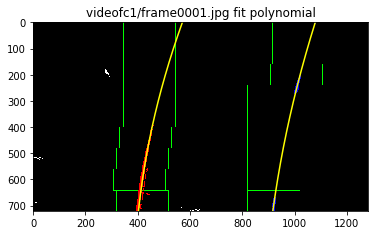

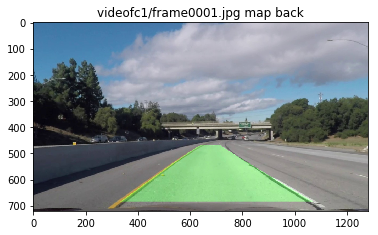

935.437219306 m 1332.46917418 m
current position is:  0.105615006349
return value is  True use_last is False
sanity check passed and will set value for line class
getfit return value is: True
count is 0


In [21]:
images = glob.glob('videofc1/frame0001.jpg')
myret=None
IsExist=False
leftLine=Line()
rightLine=Line()

count =0
reset=True
for idx, fname in enumerate(images):
    image = mpimg.imread(fname)
    img_size=(img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    image = cv2.undistort(image, mtx, dist, None, mtx)
    #points_map(image, fname)
    
    binary_warped, Minv = pipeline(image, fname)
    
    if(reset==False):
        print("step1, reset is false and will search based on last frame fit")
        myret= getfit(binary_warped, Minv, fname, True, leftLine, rightLine)
        print("myret for step1 is", myret)
        if(myret==False):
            print("step2, will search with new windows sliding")
            myret= getfit(binary_warped, Minv, fname, False, leftLine, rightLine)      
            if((myret==False)):
                print("step3, still failed and will use last frame's fit value")
                myret= getfit(binary_warped, Minv, fname, True, leftLine, rightLine, use_last=True)
                count=count+1
            else:
                count=0
        else:
            count=0
      
    else:
        print("step4, reset is True and will search from start")
        myret= getfit(binary_warped, Minv, fname, False, leftLine, rightLine)
        if((myret==False)):
            print("step5, search failed and will use last frame's value")
            myret= getfit(binary_warped, Minv, fname, True, leftLine, rightLine, use_last=True)
            count=count+1
            
    
    reset=False
    print("count is", count)
    if (count >=3):
        print("count reseted")
        reset=True
        count=0
        leftLine=Line()
        rightLine=Line()


        

In [92]:
a = [1, 2]

In [22]:
a[-9:]

[1, 2]

In [24]:
a=np.array([[0,1], [2,3]])

In [25]:
np.average(a, axis=0)

array([ 1.,  2.])

In [9]:
np.concatenate([[1,2], [3,4]])

array([1, 2, 3, 4])